# Data Preprocessing

In [18]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns   

In [19]:
#load the dataset
df = pd.read_csv("../data/processed/shot_events.csv")

print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns")

Dataset has 1494 rows and 45 columns


In [20]:
#globally set column display options
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [36]:
#preview dataframe
df.head(3)

,id,index,period,timestamp,minute,second,possession,location,duration,related_events,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,player.id,player.name,position.id,position.name,shot.statsbomb_xg,shot.end_location,shot.key_pass_id,shot.type.id,shot.type.name,shot.outcome.id,shot.outcome.name,shot.technique.id,shot.technique.name,shot.body_part.id,shot.body_part.name,shot.freeze_frame,shot.first_time,shot.one_on_one,under_pressure,shot.aerial_won,shot.open_goal,shot.deflected,out,shot.saved_to_post,shot.follows_dribble,shot.saved_off_target,shot.redirect
0,a446476e-a091-441b-bab5-fa812a3c1928,72,1,00:02:02.403,2,2,5,"[92.6, 52.0]",0.338598,"['7ca749c7-9bf2-4b85-9f92-eb6b147704c4', '8332...",16,Shot,777,Tunisia,7,From Goal Kick,777,Tunisia,23910,Youssef Msakni,21,Left Wing,0.023820,"[101.1, 47.5]",a5f9e2ed-7002-40e8-ba89-26eab7d7efc5,87,Open Play,96,Blocked,93,Normal,40,Right Foot,"[{'location': [96.6, 52.5], 'player': {'id': 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e6b6a9b1-6174-4c55-98b7-dd219e256299,183,1,00:04:10.669,4,10,13,"[114.0, 54.8]",0.105592,"['602323a5-4925-432c-a9e1-7e267bf4c0f1', 'c3a0...",16,Shot,777,Tunisia,1,Regular Play,777,Tunisia,16352,Issam Jebali,23,Center Forward,0.014060,"[114.6, 53.3]",NaN,87,Open Play,96,Blocked,93,Normal,38,Left Foot,"[{'location': [107.0, 49.4], 'player': {'id': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5fa62889-7bd9-4f7b-9cb7-25a9f9ef23a3,506,1,00:10:46.693,10,46,23,"[93.4, 44.5]",0.136106,"['905724a8-d2f7-4ad2-8638-7f95e27da5ad', 'e440...",16,Shot,777,Tunisia,4,From Throw In,777,Tunisia,9236,Mohamed Dräger,7,Right Wing Back,0.033115,"[98.1, 43.9]",6ae7f5bd-fa1f-4dd9-a83e-24c3d6c6dc2c,87,Open Play,96,Blocked,93,Normal,40,Right Foot,"[{'location': [102.1, 41.4], 'player': {'id': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#General information on dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1494 non-null   object 
 1   index                  1494 non-null   int64  
 2   period                 1494 non-null   int64  
 3   timestamp              1494 non-null   object 
 4   minute                 1494 non-null   int64  
 5   second                 1494 non-null   int64  
 6   possession             1494 non-null   int64  
 7   location               1494 non-null   object 
 8   duration               1494 non-null   float64
 9   related_events         1494 non-null   object 
 10  type.id                1494 non-null   int64  
 11  type.name              1494 non-null   object 
 12  possession_team.id     1494 non-null   int64  
 13  possession_team.name   1494 non-null   object 
 14  play_pattern.id        1494 non-null   int64  
 15  play

In [22]:
# Display all duplicate rows
duplicate_rows = df[df.duplicated(keep=False)]
print(f"Number of duplicate rows: {len(duplicate_rows)}")
print("\nDuplicate rows:")
print(duplicate_rows)

Number of duplicate rows: 0

Duplicate rows:
Empty DataFrame
Columns: [id, index, period, timestamp, minute, second, possession, location, duration, related_events, type.id, type.name, possession_team.id, possession_team.name, play_pattern.id, play_pattern.name, team.id, team.name, player.id, player.name, position.id, position.name, shot.statsbomb_xg, shot.end_location, shot.key_pass_id, shot.type.id, shot.type.name, shot.outcome.id, shot.outcome.name, shot.technique.id, shot.technique.name, shot.body_part.id, shot.body_part.name, shot.freeze_frame, shot.first_time, shot.one_on_one, under_pressure, shot.aerial_won, shot.open_goal, shot.deflected, out, shot.saved_to_post, shot.follows_dribble, shot.saved_off_target, shot.redirect]
Index: []


In [23]:
# To see which rows are exactly identical
#print("\nGrouped duplicate rows with counts:")
#duplicate_counts = df.groupby(df.columns.tolist()).size().reset_index(name='count')
#print(duplicate_counts[duplicate_counts['count'] > 1])

What is xG? 

1. The acronym stands for Expected Goals. It represents the probability of a shot resulting in a goal
    * example: xG -> 0.2: likely to score 2 goals from 10 shots

How is xG calculated?
1. Parameters: 
    *   distance to goal
    *   angle to goal
    *   body part used
    *   type of assist/previous action(through ball, cross etc)
2. The model then calculates a probability of a goal between 0 and 1 
    *   1 means absolute certainty
    *   0 means no certainty


source: StatsBomb


To build a basic xG model

*   It Requires feaures that 
    a.  are known at the moment of the shot, 
    b.  affect the likelihood of scoring  
    c.  available consistently for all shots 
 


In [24]:
#check features available
print("Features available in the dataset:")
df.columns.tolist()

Features available in the dataset:


['id',
 'index',
 'period',
 'timestamp',
 'minute',
 'second',
 'possession',
 'location',
 'duration',
 'related_events',
 'type.id',
 'type.name',
 'possession_team.id',
 'possession_team.name',
 'play_pattern.id',
 'play_pattern.name',
 'team.id',
 'team.name',
 'player.id',
 'player.name',
 'position.id',
 'position.name',
 'shot.statsbomb_xg',
 'shot.end_location',
 'shot.key_pass_id',
 'shot.type.id',
 'shot.type.name',
 'shot.outcome.id',
 'shot.outcome.name',
 'shot.technique.id',
 'shot.technique.name',
 'shot.body_part.id',
 'shot.body_part.name',
 'shot.freeze_frame',
 'shot.first_time',
 'shot.one_on_one',
 'under_pressure',
 'shot.aerial_won',
 'shot.open_goal',
 'shot.deflected',
 'out',
 'shot.saved_to_post',
 'shot.follows_dribble',
 'shot.saved_off_target',
 'shot.redirect']

#### Features for the MVP model 

Feature selection guided by research:

1.  shot.statsbomb_xg -> comparison, not for training
2.  location -> calculate distance and angle of shot
3.  shot.body_part.name -> impacts quality(foot, head, etc)
4.  shot.type.name -> open play, free kick etc
5.  under_pressure -> impacts shot accuracy 
6.  shot.technique.name -> Volley, half-volley, etc.
7.  shot.first_time -> Quicker shots often = higher xG 
8.  shot.open_goal -> Obvious predictor of scoring
9.  shot.deflected -> Adds randomness to outcome 
10. shot.one_on_one -> Big chances; should increase xG
11. shot.outcome.name -> target label


*   ids, indexes, timestamps -> these data points are not predictive of outcome, would add noise; will not be used
*   for this basic model player.name, team.name and other similar descriptors will not be included






In [30]:
#create a copy of the dataframe for further processing
df_xg= df.copy()

In [ ]:
print(f"Total no. of features: {len(df_xg.columns)}")

#remove features that end with .id 
feature_list =[feature for feature in df_xg.columns.tolist() if not ".id" in feature.lower()]
print(f"Total no. of features: {len(feature_list)}")

# Print removed features for verification
removed_features = [f for f in df_xg.columns if f not in feature_list]
print(f"\nRemoved features: \n{removed_features}")

Total no. of features: 45
Total no. of features: 35

Removed features: 
['type.id', 'possession_team.id', 'play_pattern.id', 'team.id', 'player.id', 'position.id', 'shot.type.id', 'shot.outcome.id', 'shot.technique.id', 'shot.body_part.id']


In [40]:
#features to be removed
features_to_remove= ['id','index','period','timestamp','minute','second', 'possession',
                     'duration', 'related_events','possession_team.name','team.name',
                     'player.name','position.name','shot.key_pass_id','shot.freeze_frame','out'
                     ]

#updated feature list
feature_list_updated = [f for f in feature_list if f not in features_to_remove]
print(f"\nUpdated features: \n{feature_list_updated}")
print(f"Total no. of features: {len(feature_list_updated)}")



Updated features: 
['location', 'type.name', 'play_pattern.name', 'shot.statsbomb_xg', 'shot.end_location', 'shot.type.name', 'shot.outcome.name', 'shot.technique.name', 'shot.body_part.name', 'shot.first_time', 'shot.one_on_one', 'under_pressure', 'shot.aerial_won', 'shot.open_goal', 'shot.deflected', 'shot.saved_to_post', 'shot.follows_dribble', 'shot.saved_off_target', 'shot.redirect']
Total no. of features: 19


In [42]:
#update dataframe
df_xg = df_xg[feature_list_updated]

#verify changes
print(f"Dataframe now has {len(df_xg.columns)} columns")
print(f"\nList of features in df_xg: \n{df_xg.columns.tolist()}")

Dataframe now has 19 columns

List of features in df_xg: 
['location', 'type.name', 'play_pattern.name', 'shot.statsbomb_xg', 'shot.end_location', 'shot.type.name', 'shot.outcome.name', 'shot.technique.name', 'shot.body_part.name', 'shot.first_time', 'shot.one_on_one', 'under_pressure', 'shot.aerial_won', 'shot.open_goal', 'shot.deflected', 'shot.saved_to_post', 'shot.follows_dribble', 'shot.saved_off_target', 'shot.redirect']


In [43]:
df_xg.head(2)

,location,type.name,play_pattern.name,shot.statsbomb_xg,shot.end_location,shot.type.name,shot.outcome.name,shot.technique.name,shot.body_part.name,shot.first_time,shot.one_on_one,under_pressure,shot.aerial_won,shot.open_goal,shot.deflected,shot.saved_to_post,shot.follows_dribble,shot.saved_off_target,shot.redirect
0,"[92.6, 52.0]",Shot,From Goal Kick,0.02382,"[101.1, 47.5]",Open Play,Blocked,Normal,Right Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[114.0, 54.8]",Shot,Regular Play,0.01406,"[114.6, 53.3]",Open Play,Blocked,Normal,Left Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
#check for missing values (percentage)
df_xg.isna().mean()*100

location                  0.000000
type.name                 0.000000
play_pattern.name         0.000000
shot.statsbomb_xg         0.000000
shot.end_location         0.000000
shot.type.name            0.000000
shot.outcome.name         0.000000
shot.technique.name       0.000000
shot.body_part.name       0.000000
shot.first_time          68.674699
shot.one_on_one          94.310576
under_pressure           84.069612
shot.aerial_won          91.365462
shot.open_goal           99.129853
shot.deflected           98.527443
shot.saved_to_post       99.799197
shot.follows_dribble     99.799197
shot.saved_off_target    99.866131
shot.redirect            99.866131
dtype: float64

In [47]:
#examine features with missingness
#1.under_pressure
print("1.under_pressure\nUnique values in 'under_pressure' feature:")
print(df_xg['under_pressure'].unique())

#2. shot.type.name
print(f"\n2.shot_type\nUnique values in 'shot.type_name': \n{df_xg['shot.type.name'].unique()}")

#3. body_part
print(f"\n3.shot.body_part.name\nUnique values in 'shot.body_part' \n{df_xg['shot.body_part.name'].unique()}")

#4 shot.first_time
print(f"\n4.shot.first_time\nUnique values in 'shot.first_time'\n{df_xg['shot.first_time'].unique()}")

#5 shot.one_on_one
print(f"\n5.shot.one_on_one\nUnique values in 'shot.one_on_one' \n{df_xg['shot.one_on_one'].unique()}")

#6 shot.aerial_won
print(f"\n6.shot.aerial_won\nUnique values in 'shot.aerial_won' \n{df_xg['shot.aerial_won'].unique()}")

#7 shot.open_goal 
print(f"\n7.shot.open_goal \nUnique values in 'shot.open_goal' \n{df_xg['shot.open_goal'].unique()}")

#8 shot.deflected
print(f"\n8.shot.deflected\nUnique values in 'shot.deflected' \n{df_xg['shot.deflected'].unique()}")

#9 shot.saved_to_post
print(f"\n9.shot.saved_to_post\nUnique values in 'shot.saved_to_post' \n{df_xg['shot.saved_to_post'].unique()}")

#10 shot.follows_dribble
print(f"\n10.shot.follows_dribble\nUnique values in 'shot.follows_dribble' \n{df_xg['shot.follows_dribble'].unique()}")

#11 shot.saved_off_target
print(f"\n11.shot.saved_off_target\nUnique values in 'shot.saved_off_target' \n{df_xg['shot.saved_off_target'].unique()}")

#12 shot.redirect
print(f"\n12.shot.redirect\nUnique values in 'shot.redirect' \n{df_xg['shot.redirect'].unique()}")



1.under_pressure
Unique values in 'under_pressure' feature:
[nan True]

2.shot_type
Unique values in 'shot.type_name': 
['Open Play' 'Corner' 'Free Kick' 'Penalty']

3.shot.body_part.name
Unique values in 'shot.body_part' 
['Right Foot' 'Left Foot' 'Head' 'Other']

4.shot.first_time
Unique values in 'shot.first_time'
[nan True]

5.shot.one_on_one
Unique values in 'shot.one_on_one' 
[nan True]

6.shot.aerial_won
Unique values in 'shot.aerial_won' 
[nan True]

7.shot.open_goal 
Unique values in 'shot.open_goal' 
[nan True]

8.shot.deflected
Unique values in 'shot.deflected' 
[nan True]

9.shot.saved_to_post
Unique values in 'shot.saved_to_post' 
[nan True]

10.shot.follows_dribble
Unique values in 'shot.follows_dribble' 
[nan True]

11.shot.saved_off_target
Unique values in 'shot.saved_off_target' 
[nan True]

12.shot.redirect
Unique values in 'shot.redirect' 
[nan True]


The features under_pressure,shot.first_time,shot.one_on_one, shot.aerial_won, shot.open_goal, shot.deflected, shot.saved_to_post, shot.follows_dribble, shot.saved_off_target, shot.redirect are  binary feature; indicating whether the event was occured (True) or not  (False).

Why is the data missing?
1.  It appears data collection intentionally recorded 'True' when the event occured. 
2.  It did not record a value for when the event did not occur

What type of Missing Data is This?
*   MNAR (Missing not at Random) ->
    *   missingness depends on the value itself
    *   missing due to how the data was collected
    *   NaN means -> the event did not occur (safe to treat as False)

Approach to handle missing value
*   Convert to binary values
    *   True -> 1
    *   NaN -> 0


In [ ]:
def manageMissing(df,features):
    """
    1.Handles missing values for Binary features i.e. [true,false], where one value is true/false
    and the other is nan.
    2.Convert non-missing value to respective binary value(1/0)
        args:
        df -> dataframe
        features -> list of features with missing value

        Returns: dataframe 
    """

    if not isinstance(df, pd.DataFrame) and isinstance(features,list):
        raise ValueError("Invalid input types. Expects Dataframe and list")
    
    try:
        df = df.copy() #for safety avoid modifying original dataframe

        for feature in features:
                #get unique non-null values
                unique_vals = df[feature].dropna().unique()
                for val in unique_vals:
                    if isinstance(val,bool) or str(val):
                        #convert to 1/0
                        if str(val).lower() == 'true' or val is True:
                            df[feature] = df[feature].fillna(0).replace({val: 1})
                        else:
                            df[feature] = df[feature].fillna(0).replace({val: 0})
                          
                #convert to integer type
                df[feature] = df[feature].astype(int)
        return df
    except Exception as e:
        print(f"Error processing features:  {str(e)}")
        return None

In [52]:
#get features with missing values
features_missing_values = [feature for feature in df_xg.columns if df_xg[feature].isna().any()]

#handle missing values
df_xg_processed = manageMissing(df=df_xg,features=features_missing_values)

# Verify changes
print("\nSample of processed features:")
print(df_xg_processed[features_missing_values].head(3))
print(f"\nConfirm if missing values present: \n{df_xg_processed.isna().mean()*100}")



Sample of processed features:
   shot.first_time  shot.one_on_one  under_pressure  shot.aerial_won  \
0                0                0               0                0   
1                0                0               0                0   
2                0                0               0                0   

   shot.open_goal  shot.deflected  shot.saved_to_post  shot.follows_dribble  \
0               0               0                   0                     0   
1               0               0                   0                     0   
2               0               0                   0                     0   

   shot.saved_off_target  shot.redirect  
0                      0              0  
1                      0              0  
2                      0              0  

Confirm if missing values present: 
location                 0.0
type.name                0.0
play_pattern.name        0.0
shot.statsbomb_xg        0.0
shot.end_location        0.0
shot.type.nam

C:\Users\On3B3\AppData\Local\Temp\ipykernel_16452\2682454084.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[feature] = df[feature].fillna(0).replace({val: 1})
C:\Users\On3B3\AppData\Local\Temp\ipykernel_16452\2682454084.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[feature] = df[feature].fillna(0).replace({val: 1})
C:\Users\On3B3\AppData\Local\Temp\ipykernel_16452\2682454084.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, 

In [53]:
#check data types
print("Data types of the features:")
print(df_xg_processed.dtypes) 

Data types of the features:
location                  object
type.name                 object
play_pattern.name         object
shot.statsbomb_xg        float64
shot.end_location         object
shot.type.name            object
shot.outcome.name         object
shot.technique.name       object
shot.body_part.name       object
shot.first_time            int32
shot.one_on_one            int32
under_pressure             int32
shot.aerial_won            int32
shot.open_goal             int32
shot.deflected             int32
shot.saved_to_post         int32
shot.follows_dribble       int32
shot.saved_off_target      int32
shot.redirect              int32
dtype: object


### Feature: Location

Closer look:

1.  The feature location is an array with two sets of values.
2.  The values represent x and y coordinates for shot take (source StatsBomb)
3.  The football pitch is a plane equal to the product of x=120 and y =80
4.  The center of the goal is y=40

In order to calculate xG:
1.  Calculate the distance from the center of goal
2.  Calcualte the angle of the shot from goal 
    a.  shot angle confined to width of the goal (top and bottom y coordinates of the goal frame)
3. The law of cosine will be used to calculate shot angle and 
4.  Pythogas theorem used to calculate shot distance

Shot.location_end: describes the final location of the shot after it was taken
                    this is could be a goal, saved shot etc.
                    this location point is not what is needed to calculate xG
                    rather the point at which the shot was taken.


# Feature engineering: extract x and y coordinates

In [54]:
sys.path.append("C:/Users/On3B3/OneDrive/Documents/Programming_Projects/xG_Model/src")
#import user-defined Class for shot calculations
from features import ShotCalculations


In [55]:
import ast

#extraxt x and y coordinates from the 'location' column
df_xg_processed['x']= df_xg_processed['location'].apply(lambda x: ast.literal_eval(x)[0])
df_xg_processed['y']= df_xg_processed['location'].apply(lambda x: ast.literal_eval(x)[1])

#convert 'x' and 'y' to float
df_xg_processed['x'] = df_xg_processed['x'].astype(float)
df_xg_processed['y'] = df_xg_processed['y'].astype(float)


In [56]:
#calculate the distance from the goal
def calculate_shot_features(row):
    #create instance for each individual shot

    shot= ShotCalculations(x=row['x'], y=row['y'])
    return pd.Series({
        'shot_distance': shot.calculate_shot_distance(),
        'shot_angle': shot.calculate_shot_angle()
    })
    
#apply the function to each row
shot_features = df_xg_processed.apply(calculate_shot_features, axis=1)

#add new features to the dataframe
df_xg_processed = pd.concat([df_xg_processed, shot_features], axis=1)

#verify the new features
print(df_xg_processed[['x','y','shot_distance','shot_angle']].head(3))

       x     y  shot_distance  shot_angle
0   92.6  52.0      29.912539    0.223755
1  114.0  54.8      15.969972    0.179792
2   93.4  44.5      26.977954    0.266085


In [58]:
#df_xg_processed.columns.tolist()

#Rename features
rename_features = ['location','type_event','play_pattern','shot_xg','shot_end_location',
                   'shot_type','shot_outcome','shot_technique','body_part',
                   'first_time_shot','1v1_shot','under_pressure','aerial_shot_won','open_goal_shot',
                   'deflected_shot','shot_saved_to_post','shot_follows_dribble','shot_saved_off_target',
                   'shot_redirected','x_coordinate','y_coordinate','shot_distance','shot_angle']

df_xg_processed.columns = rename_features

#verify changes
print(df_xg_processed.columns.tolist())

['location', 'type_event', 'play_pattern', 'shot_xg', 'shot_end_location', 'shot_type', 'shot_outcome', 'shot_technique', 'body_part', 'first_time_shot', '1v1_shot', 'under_pressure', 'aerial_shot_won', 'open_goal_shot', 'deflected_shot', 'shot_saved_to_post', 'shot_follows_dribble', 'shot_saved_off_target', 'shot_redirected', 'x_coordinate', 'y_coordinate', 'shot_distance', 'shot_angle']


In [ ]:
df_xg.head(3)

In [ ]:
#convert under_pressure to categorical
#df_xg['under_pressure'] = df_xg['under_pressure'].astype('category')

#verify the conversion
#print(f"under_pressure data type: {df_xg['under_pressure'].dtypes}")

In [ ]:
#check for missing values again
#print("Missing values after all processing:")
#print(df_xg.isna().mean() * 100)

In [59]:
# Save the processed DataFrame to a CSV file
output_path = "../data/processed/shot_events_processed.csv"
df_xg.to_csv(output_path, index=False)

# Data Visualization

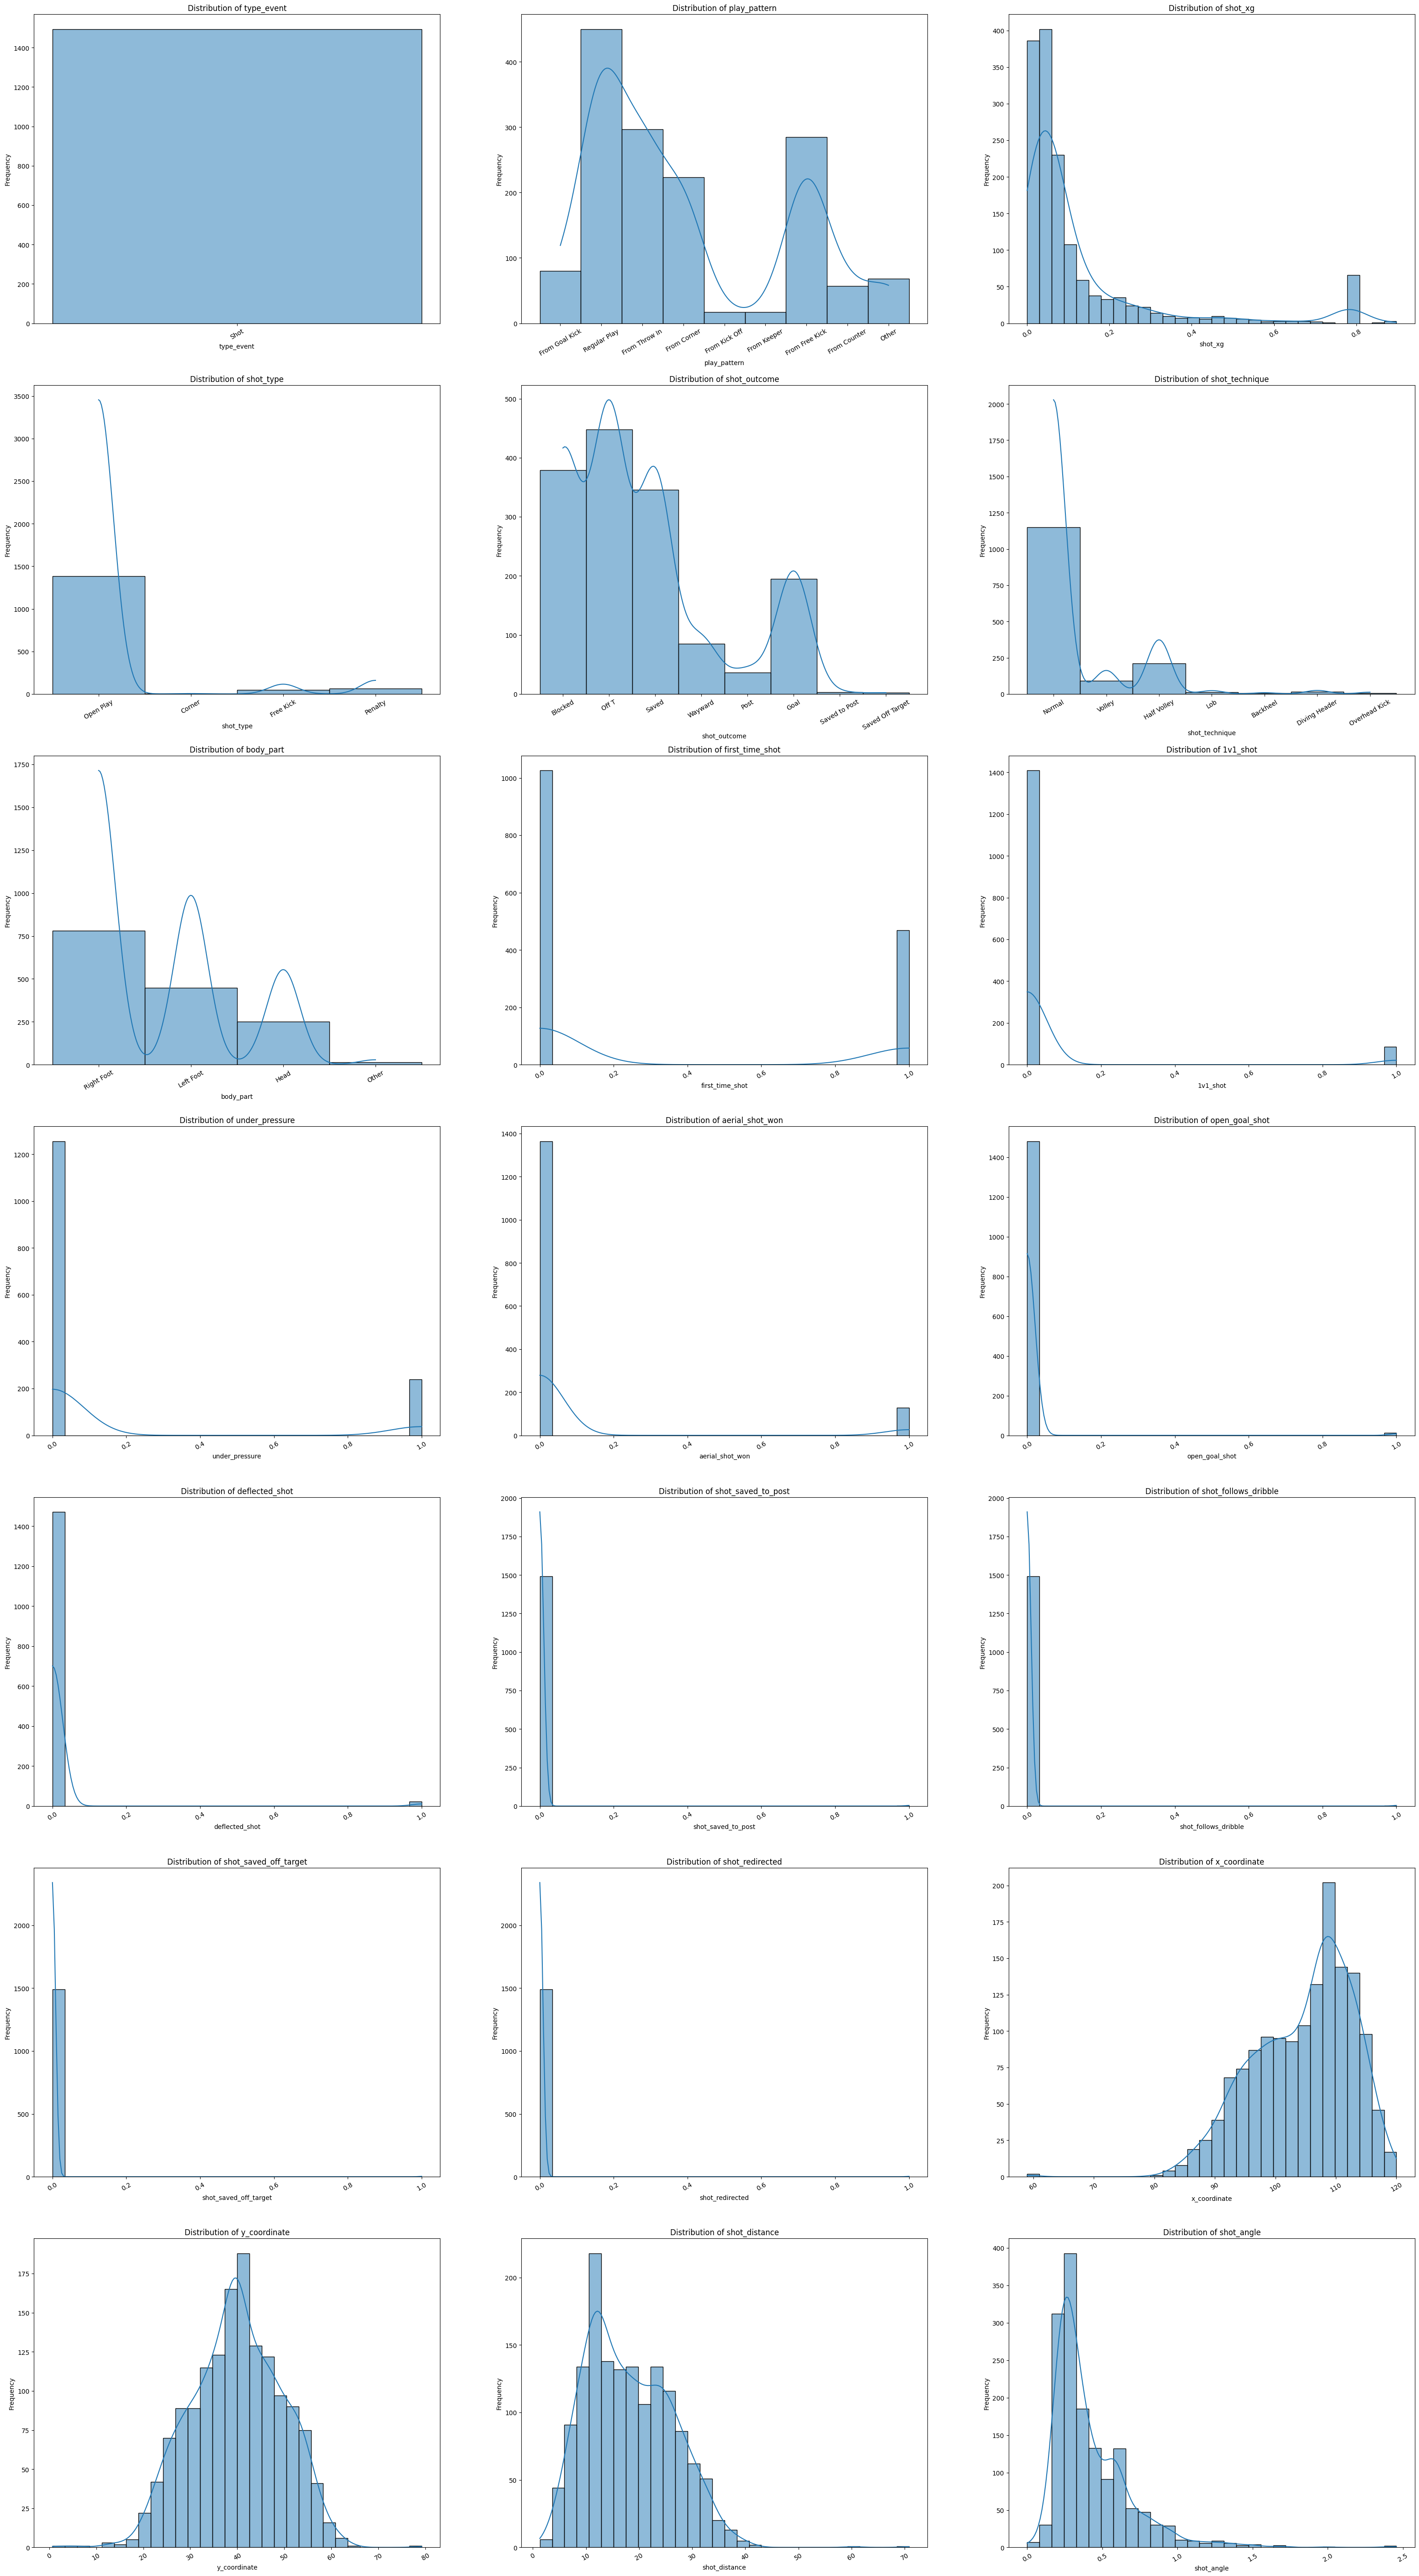

In [75]:
# 1. Histogram: Feature Distributions
features = ['type_event','play_pattern','shot_xg','shot_type','shot_outcome','shot_technique','body_part',
            'first_time_shot','1v1_shot','under_pressure','aerial_shot_won','open_goal_shot',
            'deflected_shot','shot_saved_to_post','shot_follows_dribble','shot_saved_off_target',
            'shot_redirected','x_coordinate','y_coordinate','shot_distance','shot_angle']

fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(39, 72))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.histplot(df_xg_processed[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=30)  # Add this line

In [78]:
#2. Bar Chart: Categorical Features
#categorical_features = ['body_part', 'shot_type', 'under_pressure','shot_outcome','play_pattern', 'shot_technique']
#fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 11))
#for i, feature in enumerate(categorical_features):
#    sns.barplot(data=df_xg_processed, x=feature, ax=axes[i])
#    axes[i].set_title(f'Count of {feature}')
#    axes[i].set_xlabel(feature)
#    axes[i].set_ylabel('Count')
#    axes[i].tick_params(axis='x', rotation=45)

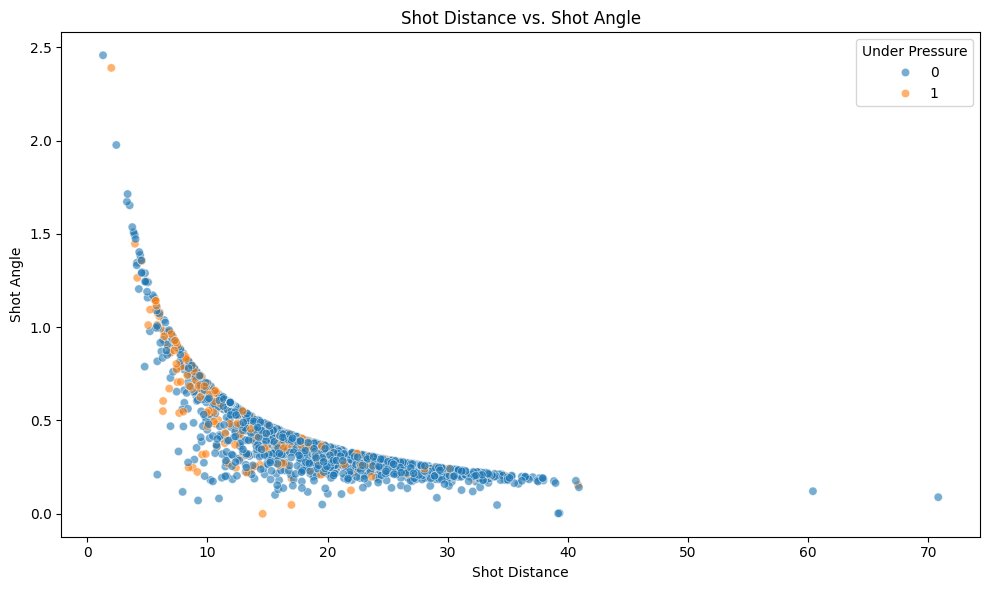

In [79]:
#3. Scatter Plot: Shot Distance vs. Shot Angle
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_xg_processed, x='shot_distance', y='shot_angle', hue='under_pressure', alpha=0.6)
plt.title('Shot Distance vs. Shot Angle')
plt.xlabel('Shot Distance')
plt.ylabel('Shot Angle')
plt.legend(title='Under Pressure')
plt.tight_layout()

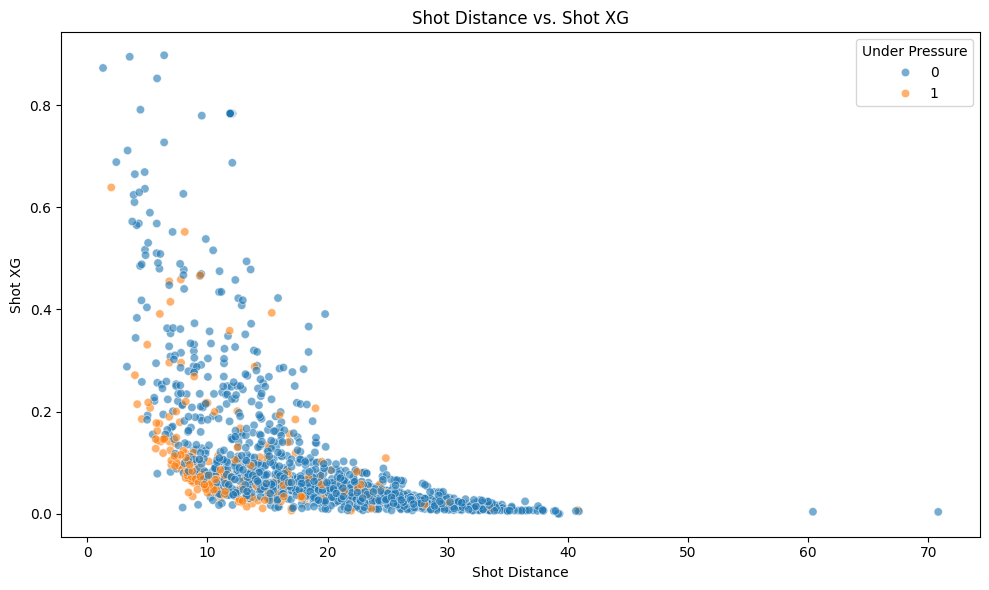

In [80]:
#4. Scatter Plot: Shot Distance vs. Shot XG
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_xg_processed, x='shot_distance', y='shot_xg', hue='under_pressure', alpha=0.6)
plt.title('Shot Distance vs. Shot XG')
plt.xlabel('Shot Distance')
plt.ylabel('Shot XG')
plt.legend(title='Under Pressure')
plt.tight_layout()

In [81]:
def draw_pitch(ax=None, pitch_length=120, pitch_width=80):
    """Function to draw a football pitch with specified dimensions."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Pitch Outline & Centre Line
    ax.plot([0, 0, pitch_length, pitch_length, 0], [0, pitch_width, pitch_width, 0, 0], color="black")
    ax.plot([pitch_length/2, pitch_length/2], [0, pitch_width], color="black")
    
    # Left Penalty Area
    ax.plot([18, 18, 0, 0, 18], [62, 18, 18, 62, 62], color="black")
    # Right Penalty Area
    ax.plot([pitch_length, pitch_length, pitch_length-18, pitch_length-18, pitch_length], 
            [62, 18, 18, 62, 62], color="black")
    
    # Left 6-yard Box
    ax.plot([6, 6, 0, 0, 6], [50, 30, 30, 50, 50], color="black")
    # Right 6-yard Box
    ax.plot([pitch_length, pitch_length, pitch_length-6, pitch_length-6, pitch_length],
            [50, 30, 30, 50, 50], color="black")
    
    # Centre Circle
    centre_circle = plt.Circle((pitch_length/2, pitch_width/2), 10, color="black", fill=False)
    ax.add_patch(centre_circle)
    
    # Penalty Spots
    ax.plot([12, pitch_length-12], [pitch_width/2, pitch_width/2], marker='o', color='black', linestyle='None')
    
    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set limits to the pitch size
    ax.set_xlim(0, pitch_length)
    ax.set_ylim(0, pitch_width)
    
    ax.set_aspect('equal')
    return ax

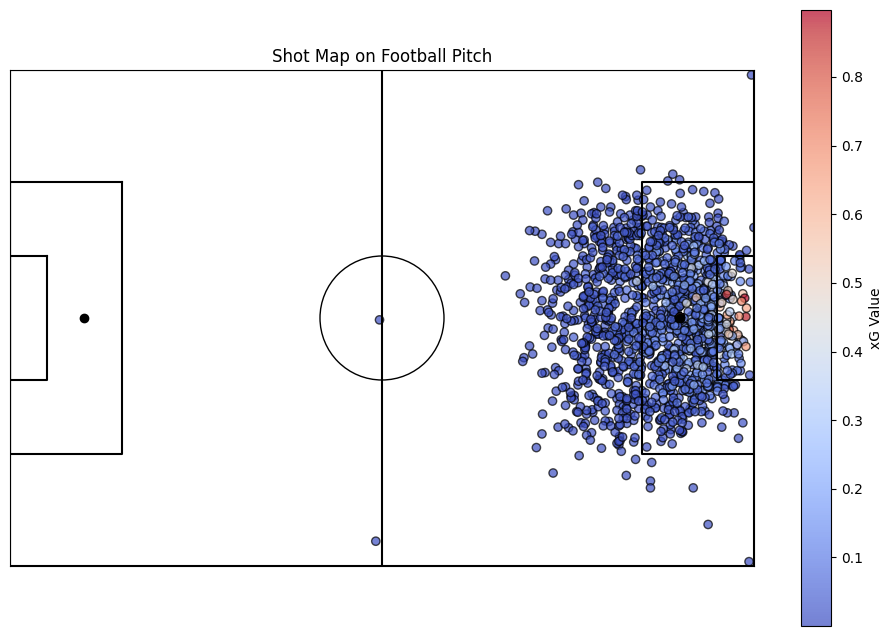

In [84]:
#5. Shot Map on Football Pitch (Scatter Plot of 'x' and 'y')
fig, ax = plt.subplots(figsize=(12, 8))
ax = draw_pitch(ax)

# Plot shots colored by xG
sc = ax.scatter(df_xg_processed['x_coordinate'], df_xg_processed['y_coordinate'], c=df_xg_processed['shot_xg'], cmap='coolwarm', alpha=0.7, edgecolors='k')

plt.colorbar(sc, label='xG Value')
plt.title('Shot Map on Football Pitch')
plt.show()

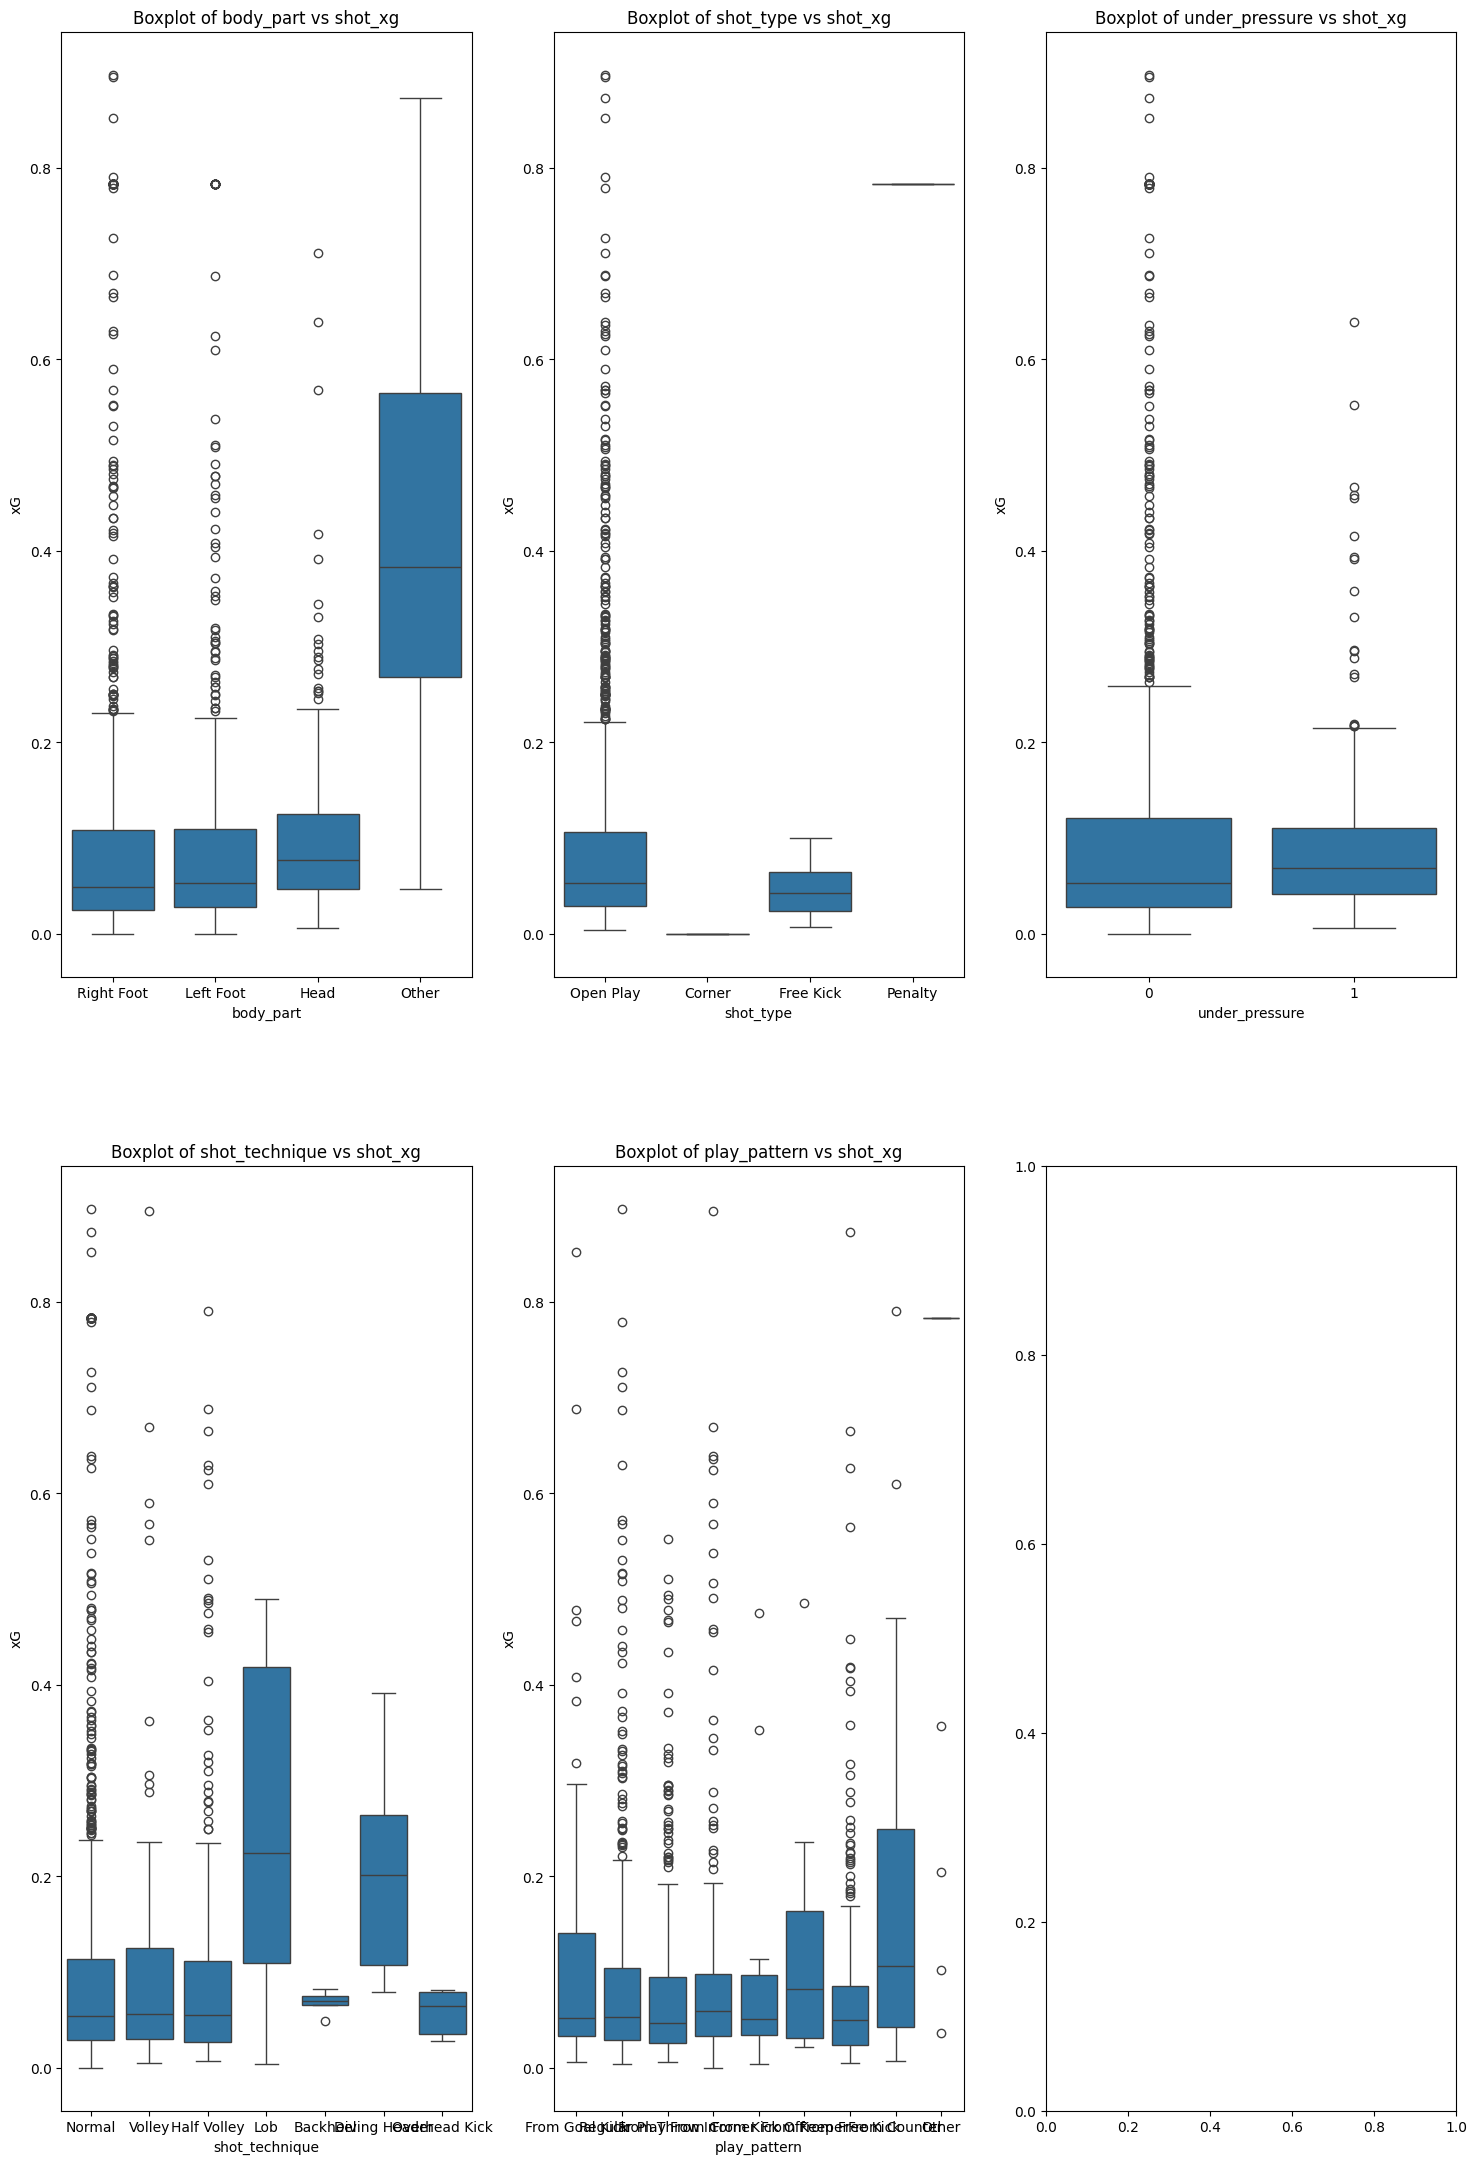

In [88]:
#6. Boxplot: Feature vs. Shot XG
features = [ 'body_part', 'shot_type', 'under_pressure','shot_technique','play_pattern']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 27))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.boxplot(x=df_xg_processed[feature],y=df_xg_processed['shot_xg'],data=df_xg_processed, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} vs shot_xg')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('xG')

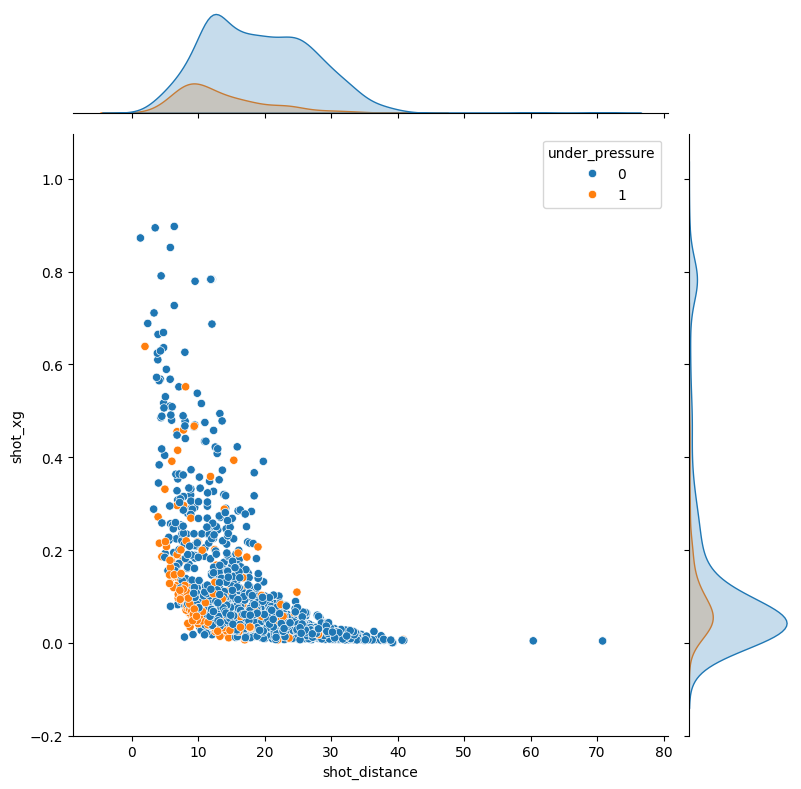

In [89]:
#7. Joint Plot: Shot Distance vs. Shot XG
sns.jointplot(data=df_xg_processed, x='shot_distance', y='shot_xg', kind='scatter', hue='under_pressure', height=8)